# Replikacija rezultata

U ovom dijelu projekta cilj je ostavariti rezultate slične onima iz originalnog znanstvenog rada. 

Prvi korak je učitati predprocesirane podatke iz prvog dijela projekta.

In [103]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly as plotly
import numpy as np
from copy import deepcopy
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

long=pd.read_csv("./longitudinal_preprocessed.csv")
long.head()

,Unnamed: 0,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,87,3.0,2.0,27.0,0.0,1987,0.696,0.883
1,1,1,88,3.0,2.0,30.0,0.0,2004,0.681,0.876
2,2,1,75,3.0,2.0,23.0,0.5,1678,0.736,1.046
3,3,1,76,3.0,2.0,28.0,0.5,1738,0.713,1.010
4,4,1,80,3.0,2.0,22.0,0.5,1698,0.701,1.034


Nakon treniranja svakog modela prikazati ćemo rezultate koje model postiže za $accuracy$, $recall$, $precision$ i $F1-score$.
Također ćemo prikazati konfuzijske matrice u kojima se jasno vidi raspodjela klasifikacije u skupine $true$ $positive$, $true$ $negative$, $false$ $positive$ i $false$ $negative$.

## Decision Tree

Prvi algoritam koji ćemo probati iskoristiti za klasifikaciju pacijenata je klasifikator stabla odluke.

Na početku svake iteracije pokretanja učenja novog modela pokrećemo funkciju $long.sample$ s argumentom $frac=1$ koji nasumično miješa podatke unutar dataframe-a.

U radu se spominje da se za određivanje optimalnih hiperparametara koristi 5-fold cross validation, pa u skladu s time u prvom odsječku koda razmatramo potencijalne maksimalne dubine stabla i određujemo optimalnu.

In [104]:
from sklearn.tree import DecisionTreeClassifier

means=[]
for depth in range(1,30):
    
    long_sample=long.sample(frac=1).reset_index(drop=True)
    
    #Oznake klasa, 0 predstavlja nedementne, a 1 dementne.
    y=long_sample['CDR']
    y.loc[y>=0.5]=1
    long_sample.drop('CDR', axis=1, inplace=True)
    x=long_sample
    
    DTC=DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    
    mean=0
    
    #5-fold cross-validation  
    for i in range(5):
    
        x_train=x.copy(deep=True)
        y_train=y.copy(deep=True)
        
        x_test=x_train[i*74:(i+1)*74]
        y_test=y_train[i*74:(i+1)*74]
        
        x_train.drop(x_train.index[i*74:(i+1)*74], inplace=True)
        y_train.drop(y_train.index[i*74:(i+1)*74], inplace=True)
        
        
        
        DTC.fit(np.array(x_train), np.array(y_train))
        
        prediction=DTC.predict(np.array(x_test))
        
        accuracy=accuracy_score(np.array(y_test), prediction)
        mean+=accuracy
        
    mean/=5

    means.append(mean)
    
print(f'Najveća preciznost je {max(means)} i ostvaruje se za max_depth od {means.index(max(means))+1}.')

C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2434661791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1
C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2434661791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1
C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2434661791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1
C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\243

Najveća preciznost je 0.8243243243243243 i ostvaruje se za max_depth od 7.


C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2434661791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1
C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2434661791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1
C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2434661791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1
C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\243

In [105]:
depth=means.index(max(means))+1

U slijedećem odsječku koda inicijaliziramo model s izračunatim hiperparametrom i izvodimo 10-fold cross validation.

In [106]:
DTC=DecisionTreeClassifier(criterion='entropy', max_depth=depth)

#Miješanje indeksa za 10-fold cross-validation
long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

acc=0
prec=0
rec=0
f=0

#10-fold cross-validation
for i in range(10):
    
    x_train=x.copy(deep=True)
    y_train=y.copy(deep=True)
        
    x_test=x_train[i*37:(i+1)*37]
    y_test=y_train[i*37:(i+1)*37]
        
    x_train.drop(x_train.index[i*37:(i+1)*37], inplace=True)
    y_train.drop(y_train.index[i*37:(i+1)*37], inplace=True)
        
        
        
    DTC.fit(np.array(x_train), np.array(y_train))
        
    prediction=DTC.predict(np.array(x_test))
        
    acc+=accuracy_score(np.array(y_test), prediction)
    rec+=recall_score(np.array(y_test), prediction)
    prec+=precision_score(np.array(y_test), prediction)
    f+=f1_score(np.array(y_test), prediction)
    
print(f'Accuracy: {acc/10}')
print(f'Precision: {prec/10}')
print(f'Recall: {rec/10}')
print(f'F-score: {f/10}')

Accuracy: 0.8108108108108109
Precision: 0.7852255639097743
Recall: 0.8138200894392845
F-score: 0.79289333390402


C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\287054748.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


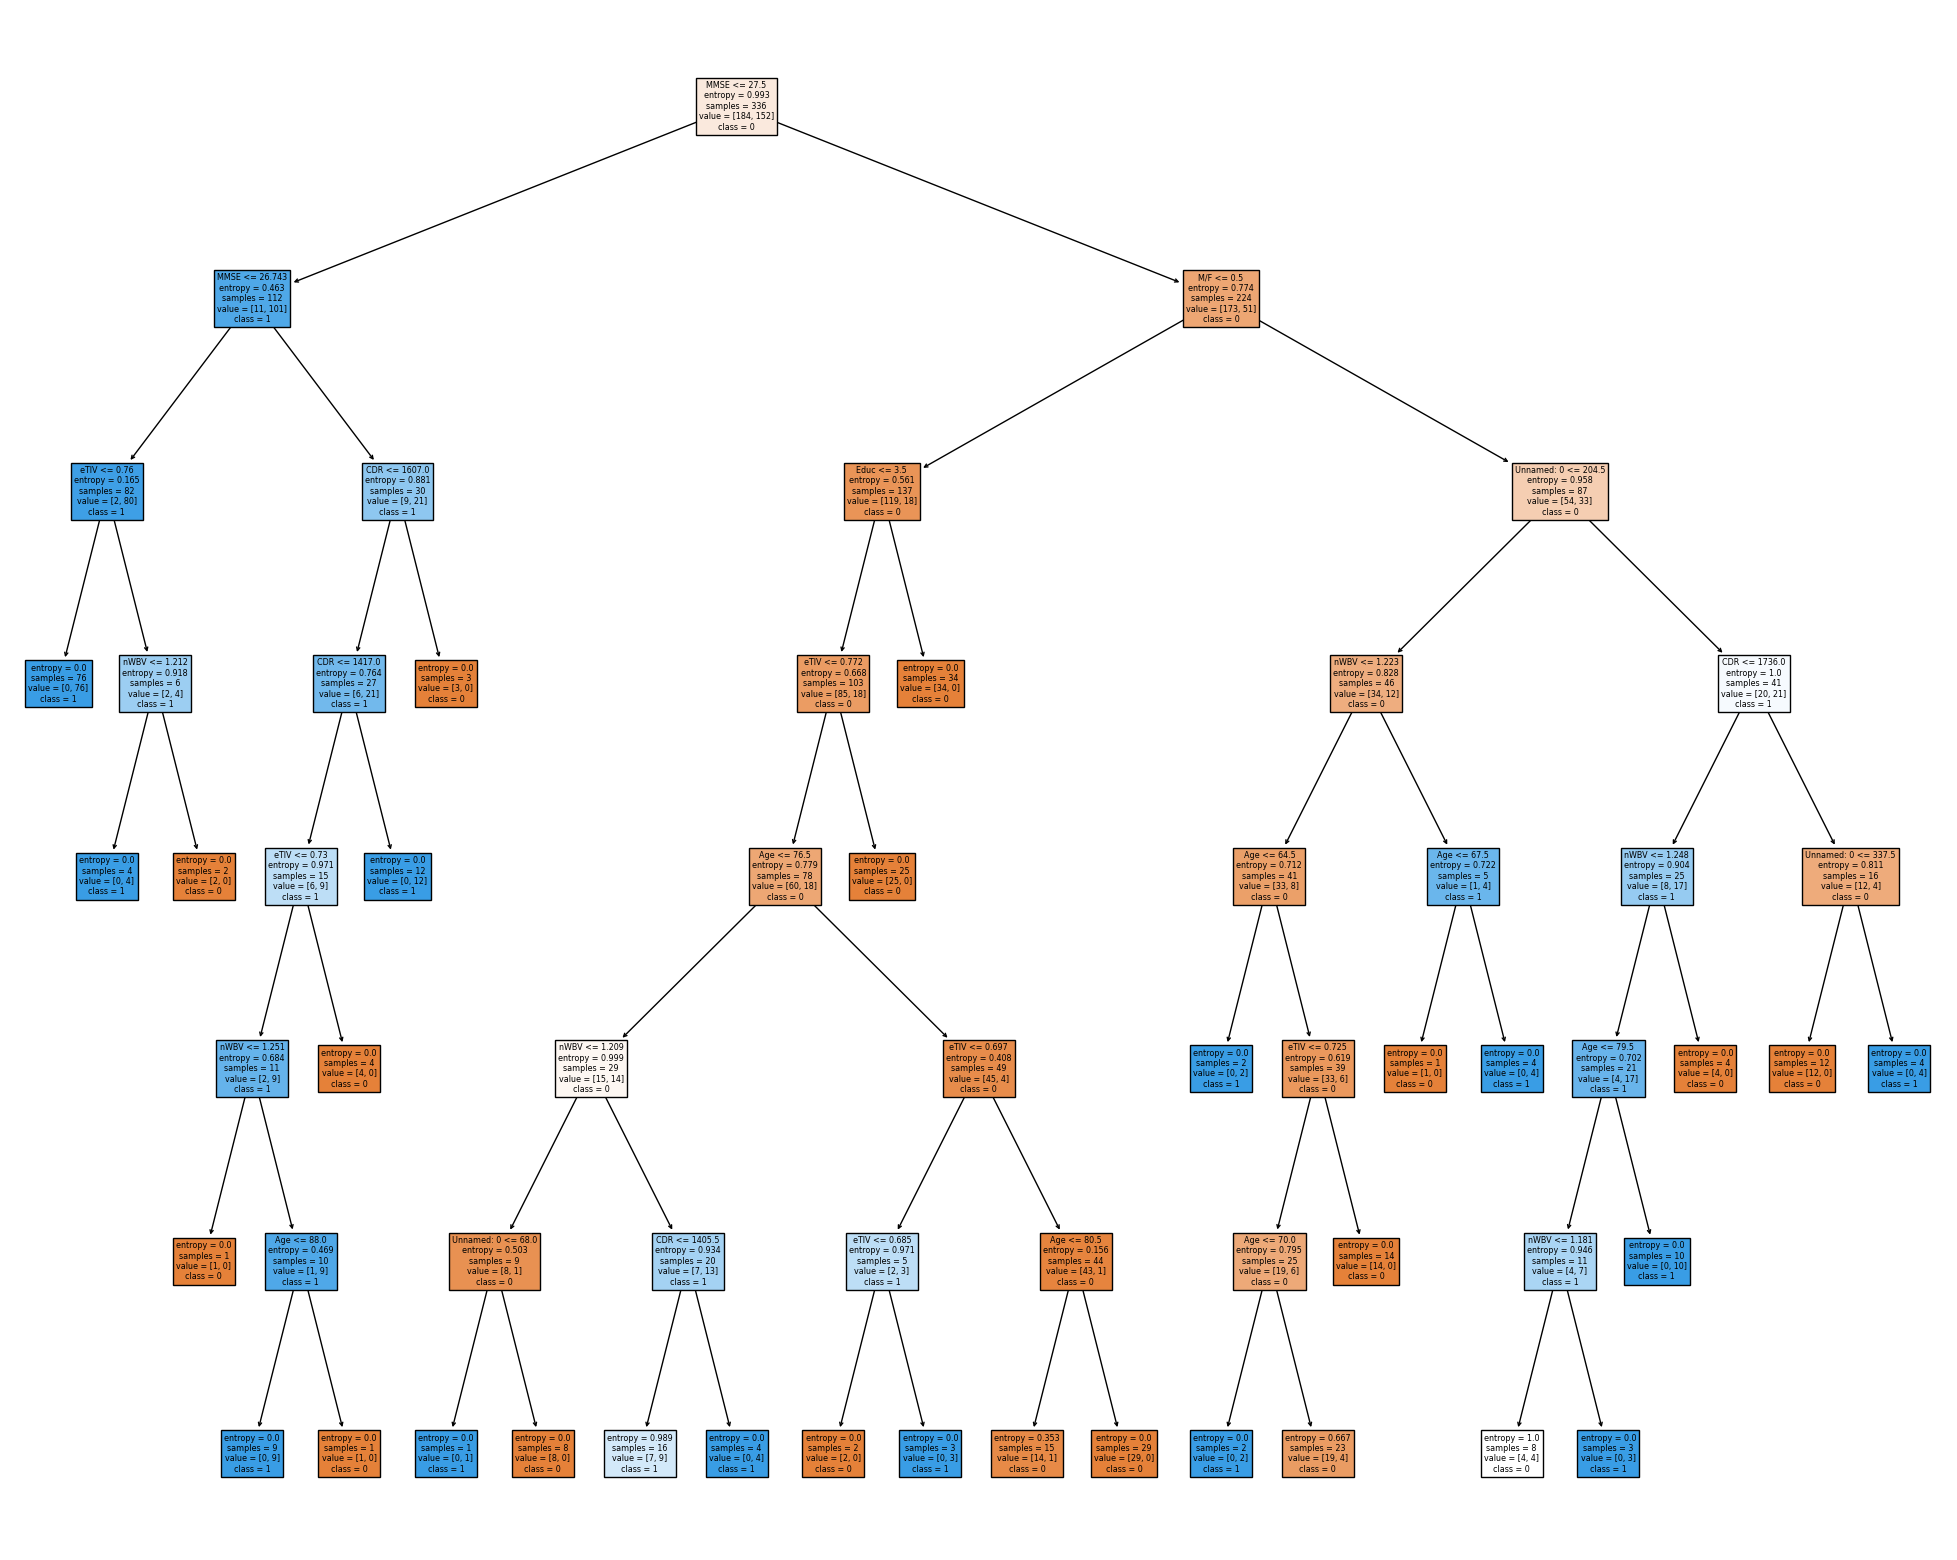

In [107]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC, 
                   feature_names=long.columns,  
                   class_names=['0','1','2','3'],
                   filled=True)

C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\1242321024.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


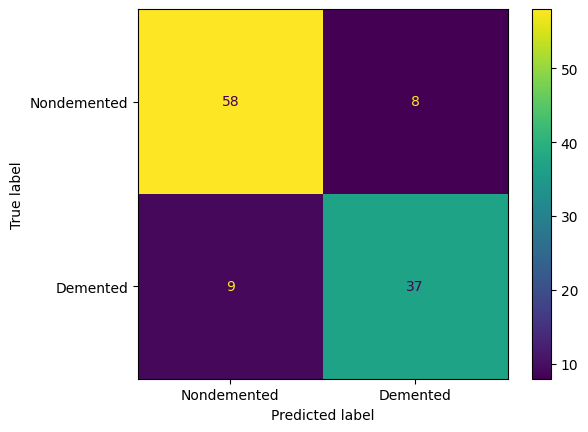

In [109]:
long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=0.7)

DTC.fit(x_train, y_train)

prediction=DTC.predict(x_test)

cfm=confusion_matrix(y_test, prediction)

cfmd=ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Nondemented', 'Demented'])

cfmd.plot()
plt.show()

## Random forest

Slijedeći algoritam je Random Forest. Na početku ponovo miješamo indekse funkcijom $sample$.

In [110]:
from sklearn.ensemble import RandomForestClassifier

RFC=RandomForestClassifier(criterion='entropy')

long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

acc=0
prec=0
rec=0
f=0

#10-fold cross-validation
for i in range(10):
    
    x_train=x.copy(deep=True)
    y_train=y.copy(deep=True)
        
    x_test=x_train[i*37:(i+1)*37]
    y_test=y_train[i*37:(i+1)*37]
        
    x_train.drop(x_train.index[i*37:(i+1)*37], inplace=True)
    y_train.drop(y_train.index[i*37:(i+1)*37], inplace=True)
        
        
        
    RFC.fit(np.array(x_train), np.array(y_train))
        
    prediction=RFC.predict(np.array(x_test))
        
    acc+=accuracy_score(np.array(y_test), prediction)
    rec+=recall_score(np.array(y_test), prediction)
    prec+=precision_score(np.array(y_test), prediction)
    f+=f1_score(np.array(y_test), prediction)
    
print(f'Accuracy: {acc/10}')
print(f'Precision: {prec/10}')
print(f'Recall: {rec/10}')
print(f'F-score: {f/10}')

C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\4133220494.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


Accuracy: 0.8432432432432433
Precision: 0.8695173453996983
Recall: 0.7654290751388275
F-score: 0.8122203864860736


C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2032817431.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


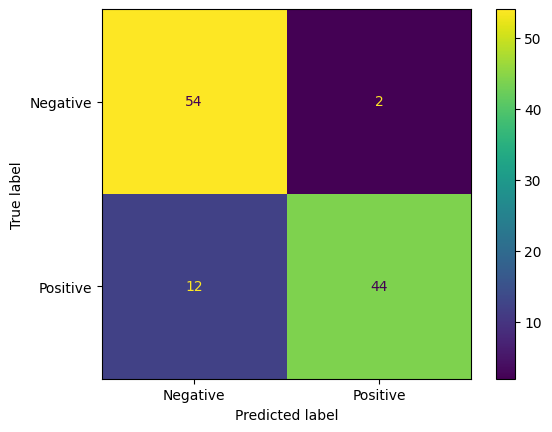

In [111]:
long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=0.7)

RFC.fit(x_train, y_train)

prediction=RFC.predict(x_test)

cfm=confusion_matrix(y_test, prediction)

cfmd=ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Negative', 'Positive'])

cfmd.plot()
plt.show()

## SVM

Slijedeći algoritam koji koristimo je SVM. 

SVM je osjetljiv na značajke različitih redova veličina pa ovdje uvodimo standardizaciju značajki (ne koristimo MinMax Scaler jer se on lošije nosi s outlierima).

Standardizaciju provodimo tako da parametre standardizacije izračunamo na skupu za učenje i onda tu istu standardizaciju primjenimo na skup za učenje i na skup za testiranje. To radimo na taj način kako bi skup za testiranje bio potpuno nepoznat modelu.

In [112]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

svm=SVC()

long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

acc=0
prec=0
rec=0
f=0

#10-fold cross-validation
for i in range(10):
    
    x_train=x.copy(deep=True)
    y_train=y.copy(deep=True)
        
    x_test=x_train[i*37:(i+1)*37]
    y_test=y_train[i*37:(i+1)*37]
    
        
    x_train.drop(x_train.index[i*37:(i+1)*37], inplace=True)
    y_train.drop(y_train.index[i*37:(i+1)*37], inplace=True)
        
    scaler.fit(x_train)
        
    svm.fit(np.array(scaler.transform(x_train)), np.array(y_train))
        
    prediction=svm.predict(np.array(scaler.transform(x_test)))
        
    acc+=accuracy_score(np.array(y_test), prediction)
    rec+=recall_score(np.array(y_test), prediction)
    prec+=precision_score(np.array(y_test), prediction)
    f+=f1_score(np.array(y_test), prediction)
    
    
print(f'Accuracy: {acc/10}')
print(f'Precision: {prec/10}')
print(f'Recall: {rec/10}')
print(f'F-score: {f/10}')

Accuracy: 0.8216216216216216
Precision: 0.8705539232009821
Recall: 0.6995861204013377
F-score: 0.7703082984144677


C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\1248423398.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\1865552211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


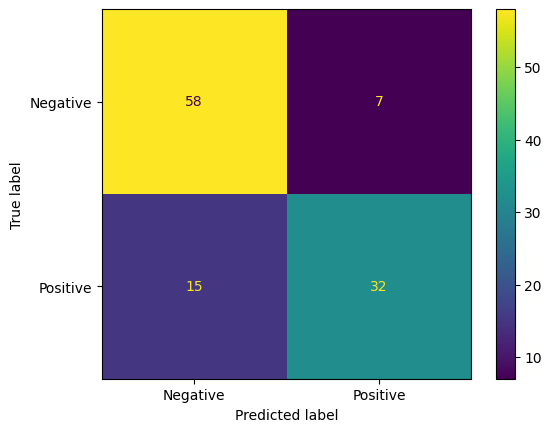

In [113]:
long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=0.7)

scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

svm.fit(x_train, y_train)

prediction=svm.predict(x_test)
cfm=confusion_matrix(y_test, prediction)

cfmd=ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Negative', 'Positive'])

cfmd.plot()
plt.show()

## XGBoost

Slijedeći algoritam je XGBoost. 

XGBoost koristi stabla odluke tako da nije potrebno raditi standardizaciju značajki.

In [114]:
import xgboost as xgb

xgbc=xgb.XGBClassifier()

long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

acc=0
prec=0
rec=0
f=0
for i in range(10):
    
    x_train=x.copy(deep=True)
    y_train=y.copy(deep=True)
        
    x_test=x_train[i*37:(i+1)*37]
    y_test=y_train[i*37:(i+1)*37]
        
    x_train.drop(x_train.index[i*37:(i+1)*37], inplace=True)
    y_train.drop(y_train.index[i*37:(i+1)*37], inplace=True)  
        
    xgbc.fit(np.array(x_train), np.array(y_train))
        
    prediction=xgbc.predict(np.array(x_test))
        
    acc+=accuracy_score(np.array(y_test), prediction)
    rec+=recall_score(np.array(y_test), prediction)
    prec+=precision_score(np.array(y_test), prediction)
    f+=f1_score(np.array(y_test), prediction)
    
    
print(f'Accuracy: {acc/10}')
print(f'Precision: {prec/10}')
print(f'Recall: {rec/10}')
print(f'F-score: {f/10}')

C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\1393574506.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


Accuracy: 0.8594594594594595
Precision: 0.8703741424105875
Recall: 0.8211467848008768
F-score: 0.838115508658112


C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\3039257160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


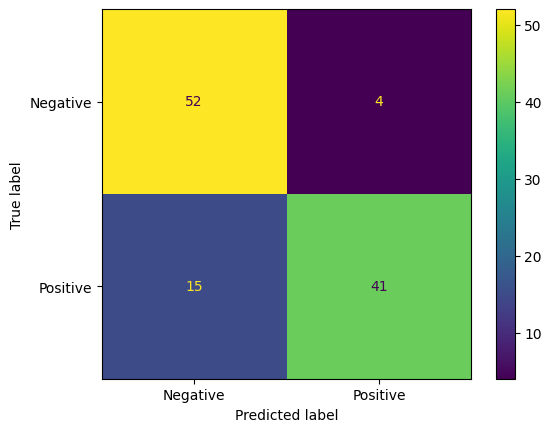

In [115]:
long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=0.7)

xgbc.fit(x_train, y_train)

prediction=xgbc.predict(x_test)

cfm=confusion_matrix(y_test, prediction)

cfmd=ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Negative', 'Positive'])

cfmd.plot()
plt.show()

# Voting

## Hard voting

Slijedeći algoritam je Hard Voting. 

Hard voting uzima nekoliko modela klasifikacije i kao predikciju vraća najčešću predviđenu vrijednost među tim modelima.

U ovom slučaju ćemo kao modele koristiti modele iz prijašnjih klasifikacija.

Ovdje također koristimo standardizaciju značajki jer je SVM osjetljiv na različite skale značajki.

In [116]:
from sklearn.ensemble import VotingClassifier

estimators=[('dtc', DTC), ('rfc', RFC), ('svm', svm), ('xgb', xgbc)]

vc=VotingClassifier(estimators=estimators)

scaler=StandardScaler()

acc=0
prec=0
rec=0
f=0
for i in range(10):
    
    x_train=x.copy(deep=True)
    y_train=y.copy(deep=True)
        
    x_test=x_train[i*37:(i+1)*37]
    y_test=y_train[i*37:(i+1)*37]
        
    x_train.drop(x_train.index[i*37:(i+1)*37], inplace=True)
    y_train.drop(y_train.index[i*37:(i+1)*37], inplace=True)
        
    scaler.fit(x_train)
        
    vc.fit(np.array(scaler.transform(x_train)), np.array(y_train))
        
    prediction=vc.predict(np.array(scaler.transform(x_test)))
        
    acc+=accuracy_score(np.array(y_test), prediction)
    rec+=recall_score(np.array(y_test), prediction)
    prec+=precision_score(np.array(y_test), prediction)
    f+=f1_score(np.array(y_test), prediction)
    
print(f'Accuracy: {acc/10}')
print(f'Precision: {prec/10}')
print(f'Recall: {rec/10}')
print(f'F-score: {f/10}')

Accuracy: 0.854054054054054
Precision: 0.9066363783275548
Recall: 0.7608769365869917
F-score: 0.8230187536248919


C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2264340988.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


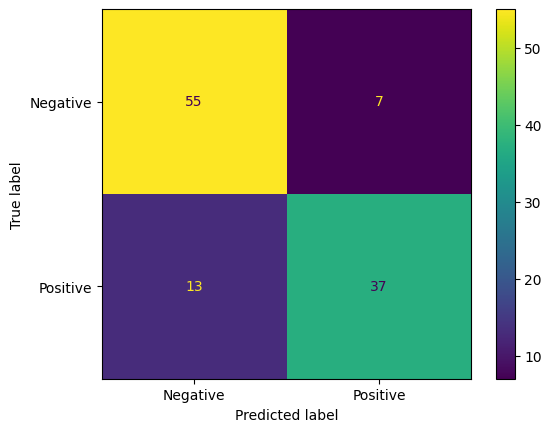

In [117]:
long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=0.7)

vc.fit(x_train, y_train)

prediction=vc.predict(x_test)

cfm=confusion_matrix(y_test, prediction)

cfmd=ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Negative', 'Positive'])

cfmd.plot()
plt.show()

## Soft voting

Soft voting se razlikuje od Hard voting-a jer pri predikciji koristi probabilističke predikcije predanih modela, te ne izlazu daje predikciju koja ima najveću sumu vjerojatnosti.

Moramo dodati argument $probability=True$ pri inicijalizaciji SVM-a jer je po default-u postavljen na False.

In [118]:
estimators=[('dtc', DTC), ('rfc', RFC), ('svm', SVC(probability=True)), ('xgb', xgbc)]

vc=VotingClassifier(estimators=estimators, voting='soft')

scaler=StandardScaler()

acc=0
prec=0
rec=0
f=0
for i in range(10):
    
    x_train=x.copy(deep=True)
    y_train=y.copy(deep=True)
        
    x_test=x_train[i*37:(i+1)*37]
    y_test=y_train[i*37:(i+1)*37]
        
    x_train.drop(x_train.index[i*37:(i+1)*37], inplace=True)
    y_train.drop(y_train.index[i*37:(i+1)*37], inplace=True)
        
    scaler.fit(x_train)
        
    vc.fit(np.array(scaler.transform(x_train)), np.array(y_train))
        
    prediction=vc.predict(np.array(scaler.transform(x_test)))
        
    acc+=accuracy_score(np.array(y_test), prediction)
    rec+=recall_score(np.array(y_test), prediction)
    prec+=precision_score(np.array(y_test), prediction)
    f+=f1_score(np.array(y_test), prediction)
    
print(f'Accuracy: {acc/10}')
print(f'Precision: {prec/10}')
print(f'Recall: {rec/10}')
print(f'F-score: {f/10}')

Accuracy: 0.8729729729729729
Precision: 0.8649932523616736
Recall: 0.8332240274345537
F-score: 0.8449754849268091


C:\Users\jurin\AppData\Local\Temp\ipykernel_2908\2264340988.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y>=0.5]=1


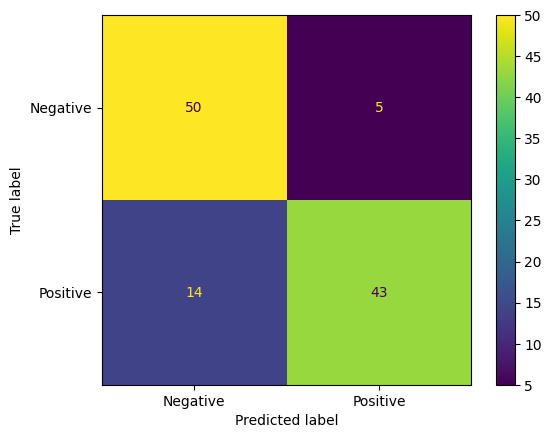

In [119]:
long_sample=long.sample(frac=1).reset_index(drop=True)

#Oznake klasa
y=long_sample['CDR']
y.loc[y>=0.5]=1
long_sample.drop('CDR', axis=1, inplace=True)
x=long_sample

x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=0.7)

vc.fit(x_train, y_train)

prediction=vc.predict(x_test)

cfm=confusion_matrix(y_test, prediction)

cfmd=ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Negative', 'Positive'])

cfmd.plot()
plt.show()